In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import ast

In [2]:
'''# Load dataset from GitHub or OSF.io (Replace with your actual URL)
data_url_istanbul_q1 = "https://github.com/your_repo/istanbul-q1.csv"
data_url_istanbul_q3 = "https://github.com/your_repo/istanbul-q3.csv"
data_url_athens = "https://github.com/your_repo/athens.csv"

istanbul_q1 = pd.read_csv(data_url_istanbul_q1)
istanbul_q3 = pd.read_csv(data_url_istanbul_q3)
athens = pd.read_csv(data_url_athens)

df_list = [istanbul_q1, istanbul_q3, athens]
'''

'# Load dataset from GitHub or OSF.io (Replace with your actual URL)\ndata_url_istanbul_q1 = "https://github.com/your_repo/istanbul-q1.csv"\ndata_url_istanbul_q3 = "https://github.com/your_repo/istanbul-q3.csv"\ndata_url_athens = "https://github.com/your_repo/athens.csv"\n\nistanbul_q1 = pd.read_csv(data_url_istanbul_q1)\nistanbul_q3 = pd.read_csv(data_url_istanbul_q3)\nathens = pd.read_csv(data_url_athens)\n\ndf_list = [istanbul_q1, istanbul_q3, athens]\n'

In [3]:
# File paths
cd = '/Users/amh/Documents/GIT/DA3_EDP25/Assignment 2/Data/'
istanbul_q1 = pd.read_csv(cd + 'istanbul-q1.csv')
istanbul_q3 = pd.read_csv(cd + 'istanbul-q3.csv')
athens = pd.read_csv(cd +'athens.csv')

df_list = [istanbul_q1, istanbul_q3, athens]

In [4]:
print(f"Istanbul Q1 size: {istanbul_q1.shape}")
print(f"Istanbul Q3 size: {istanbul_q3.shape}")
print(f"Athens size: {athens.shape}")

Istanbul Q1 size: (34446, 18)
Istanbul Q3 size: (29101, 18)
Athens size: (14642, 75)


In [20]:
print(istanbul_q1['room_type'].unique())

print(istanbul_q1['neighbourhood'].unique())


['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']
['Besiktas' 'Sariyer' 'Sisli' 'Beyoglu' 'Sancaktepe' 'Beykoz' 'Kadikoy'
 'Uskudar' 'Beylikduzu' 'Basaksehir' 'Fatih' 'Pendik' 'Bagcilar' 'Adalar'
 'Kagithane' 'Maltepe' 'Gaziosmanpasa' 'Bahcelievler' 'Gungoren'
 'Esenyurt' 'Bakirkoy' 'Kartal' 'Zeytinburnu' 'Eyup' 'Kucukcekmece'
 'Atasehir' 'Umraniye' 'Tuzla' 'Sile' 'Buyukcekmece' 'Avcilar'
 'Bayrampasa' 'Esenler' 'Arnavutkoy' 'Cekmekoy' 'Sultanbeyli' 'Catalca'
 'Silivri' 'Sultangazi']


In [21]:
def preprocess_data(df):
    df = df.copy()
    
    # Define expected columns
    selected_cols = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", 
                     "calculated_host_listings_count", "availability_365", "number_of_reviews_ltm", 
                     "room_type", "neighbourhood", "last_review"]
    
    # Check if 'amenities' exists before adding it
    if 'amenities' in df.columns:
        selected_cols.append("amenities")

    # Ensure only available columns are selected
    df = df[[col for col in selected_cols if col in df.columns]]
    
    # Handle missing values
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)
    df["number_of_reviews_ltm"] = df["number_of_reviews_ltm"].fillna(0)
    
    # Handle last review date
    if "last_review" in df.columns:
        df["last_review"] = pd.to_datetime(df["last_review"], errors='coerce')
        df["days_since_last_review"] = (pd.to_datetime("today") - df["last_review"]).dt.days
        df.drop(columns=["last_review"], inplace=True)
    
    # Convert price to numeric
    df["price"] = df["price"].replace({'\\$': '', ',': ''}, regex=True).astype(float)
    
    # Extract amenities if present
    if "amenities" in df.columns:
        import ast
        df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
        important_amenities = ['Wifi', 'Air conditioning', 'Kitchen', 'Washer', 'Heating']
        
        for amenity in important_amenities:
            df[f'has_{amenity.lower().replace(" ", "_")}'] = df['amenities'].apply(lambda x: amenity in x)
        
        df.drop(columns=['amenities'], inplace=True)
    
    return df


In [6]:
# Apply preprocessing
df_istanbul_q1 = preprocess_data(df_list[0])
df_istanbul_q3 = preprocess_data(df_list[1])
df_athens = preprocess_data(df_list[2])

In [7]:
# Use the first dataset (istanbul_q1) for model training
df_clean = df_istanbul_q1

# Train-test split
X = df_clean.drop(columns=["price"])
y = df_clean["price"].fillna(df_clean["price"].median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:
# Define preprocessing for numerical and categorical features
numeric_features = ["minimum_nights", "number_of_reviews", "reviews_per_month", 
                    "calculated_host_listings_count", "availability_365", "number_of_reviews_ltm", 
                    "days_since_last_review"]
categorical_features = ["room_type", "neighbourhood"]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [9]:

# Define models
models = {
    "OLS": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    "LASSO": Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=0.1))
    ]),
    "RandomForest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=100, random_state=42))
    ])
}

In [10]:

# Train and evaluate models
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    y_pred = model.predict(X_test)
    
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
        "Time (seconds)": round(end_time - start_time, 2)
    }

In [11]:
# Compare models
results_df = pd.DataFrame(results).T
print(results_df)

                          RMSE        R2  Time (seconds)
OLS                9269.794662 -0.055385            0.30
LASSO              9269.285453 -0.055269            1.15
RandomForest      13806.130247 -1.341071           18.84
GradientBoosting  16178.941117 -2.214925            3.93
XGBoost           10598.832487 -0.379707            0.32


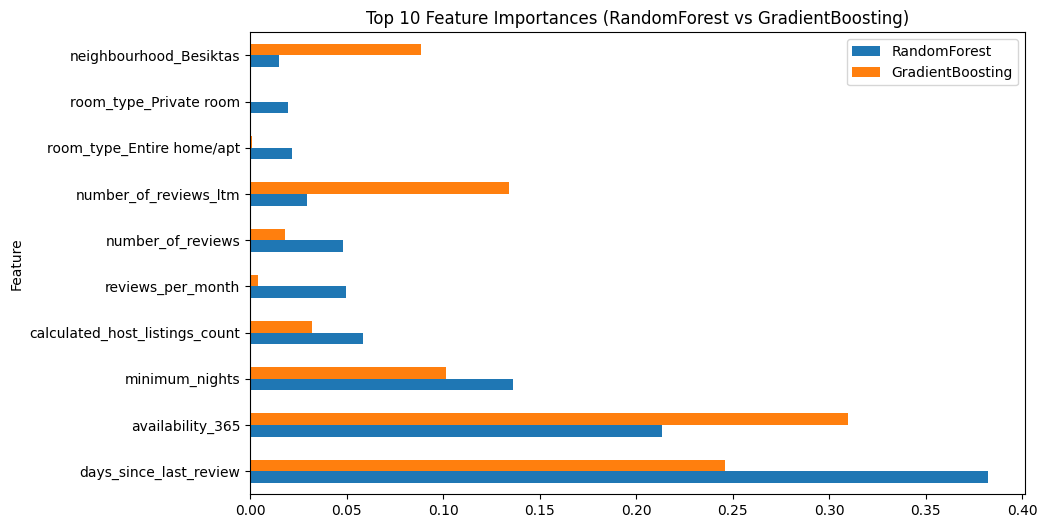

In [12]:
# Feature importance comparison
def compare_feature_importances(models, X):
    encoded_cat_features = models["RandomForest"].named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_features, encoded_cat_features])

    rf_importance = models["RandomForest"].named_steps['model'].feature_importances_
    gb_importance = models["GradientBoosting"].named_steps['model'].feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': all_feature_names,
        'RandomForest': rf_importance,
        'GradientBoosting': gb_importance
    })

    feature_importances.set_index("Feature", inplace=True)
    feature_importances.nlargest(10, columns=['RandomForest', 'GradientBoosting']).plot(kind='barh', figsize=(10,6))
    plt.title("Top 10 Feature Importances (RandomForest vs GradientBoosting)")
    plt.show()

compare_feature_importances(models, X_train)

In [14]:
# Preprocess validation datasets
df_istanbul_q3 = preprocess_data(istanbul_q3)  # Later quarter
df_athens = preprocess_data(athens)            # Another city

# Apply trained models to new datasets
for df, name in zip([df_istanbul_q3, df_athens], ["Istanbul Q3", "Athens"]):
    X_new = df.drop(columns=["price"])
    y_new = df["price"].fillna(df["price"].median())  # Ensure no missing values

    results_new = {}
    for model_name, model in models.items():
        y_pred_new = model.predict(X_new)
        results_new[model_name] = {
            "RMSE": np.sqrt(mean_squared_error(y_new, y_pred_new)),
            "R2": r2_score(y_new, y_pred_new)
        }

    print(f"\n📊 Results for {name}:")
    print(pd.DataFrame(results_new).T)



📊 Results for Istanbul Q3:
                          RMSE        R2
OLS               27340.423663 -0.008605
LASSO             27340.278803 -0.008594
RandomForest      33086.481663 -0.477106
GradientBoosting  29221.230547 -0.152146
XGBoost           45685.688495 -1.816247

📊 Results for Athens:
                         RMSE          R2
OLS               2801.258032  -88.039133
LASSO             2452.513371  -67.249183
RandomForest      4488.297768 -227.579887
GradientBoosting  3427.787601 -132.322208
XGBoost           4788.831749 -259.215911
